## Loan Prediction Outcomes

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import streamlit as st

## Loading and Exploring dataset

In [2]:
df = pd.read_excel("Banking Data.xlsx")
#df.info()
#print(df.shape)
#df.head()
#df.describe()

## Checking and Handling Missing Values

In [3]:
#df.isnull().sum().sort_values(ascending=False)

## Handling Outiers

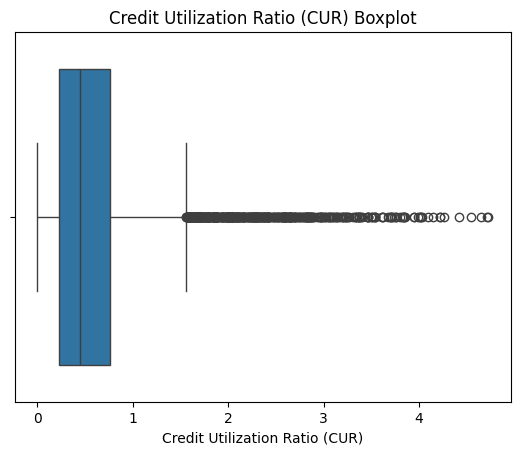

In [4]:
sns.boxplot(x=df['Credit Utilization Ratio (CUR)'])
plt.title("Credit Utilization Ratio (CUR) Boxplot")
#Save plot
plt.savefig("CUR 1.png", dpi=300)
plt.show()

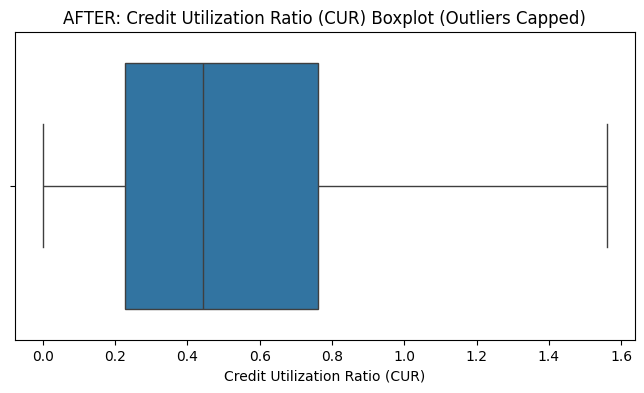

In [5]:
# Eliminating Outliers
#  Handle Outliers using IQR capping
Q1 = df['Credit Utilization Ratio (CUR)'].quantile(0.25)
Q3 = df['Credit Utilization Ratio (CUR)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers
df['Credit Utilization Ratio (CUR)'] = df['Credit Utilization Ratio (CUR)'].clip(lower_bound, upper_bound)

# Step 3: Visualize after capping
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Credit Utilization Ratio (CUR)'])
plt.title("AFTER: Credit Utilization Ratio (CUR) Boxplot (Outliers Capped)")
#Save plot
#plt.savefig("CUR 2.png", dpi=300)
plt.show()

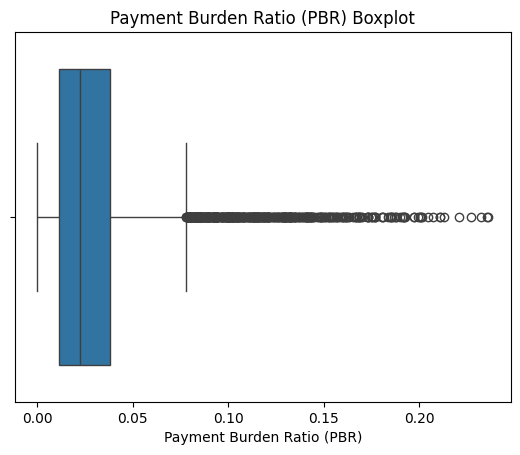

In [6]:
sns.boxplot(x=df['Payment Burden Ratio (PBR)'])
plt.title("Payment Burden Ratio (PBR) Boxplot")

#Save plot
#plt.savefig("PBR 1.png", dpi=300)
plt.show()

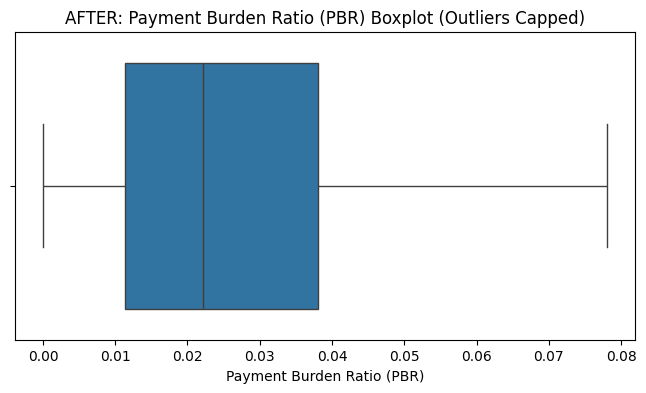

In [7]:
# Step 2: Handle Outliers using IQR capping
Q1 = df['Payment Burden Ratio (PBR)'].quantile(0.25)
Q3 = df['Payment Burden Ratio (PBR)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers
df['Payment Burden Ratio (PBR)'] = df['Payment Burden Ratio (PBR)'].clip(lower_bound, upper_bound)

# Step 3: Visualize after capping
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Payment Burden Ratio (PBR)'])
plt.title("AFTER: Payment Burden Ratio (PBR) Boxplot (Outliers Capped)")

#Save plot
#plt.savefig("PBR 2.png", dpi=300)
plt.show()

## Creating Innovative Feature Engineering

In [8]:
# Monthly Installment
df['Monthly_Installment'] = df['Loan Amount'] / df['Loan Term']

# CUR Score
df['CUR_Score'] = df['CUR Category'].map({'Over the Limit': 2, 'Moderate': 1, 'Low': 0})

# Credit Usage Ratio
df['Credit_Usage_Ratio'] = df['Credit Card Balance'] / (df['Credit Limit'] + 1)

# Debt Burden Score
df['Debt_Burden_Score'] = (df['Loan Amount'] + df['Credit Card Balance']) / (df['Account Balance'] + 1)

# Trust Index
df['Trust_Index'] = (df['Account Age (Years)'] * df['Credit Limit']) / (df['Loan Amount'] + 1)


## Binary Target Creation

In [9]:
df['Debt_Burden_Score'] = (df['Loan Amount'] + df['Credit Card Balance']) / (df['Account Balance'] + 1)

df['Qualified_Approval'] = np.where(
    ((df['Loan Status'].isin(['Approved', 'Closed'])) &
     (df['CUR Category'].isin(['Low', 'Moderate'])) &
     (df['Debt_Burden_Score'] < 2.5) &
     (df['Account Age (Years)'] > 2)),
    1,
    0
)

In [10]:
# Helps to see Class Distribution, so you would know if they are balanced or imbalanced
df['Qualified_Approval'].value_counts(normalize=True)


Qualified_Approval
0    0.916
1    0.084
Name: proportion, dtype: float64

## Training / Testing split

In [11]:
# Feature for Prediction X
features = [
    'Monthly_Installment', 'Account Age (Years)', 'Loan Amount', 'Interest Rate',
    'Credit Limit', 'Credit Card Balance',
     'Credit_Usage_Ratio', 'Debt_Burden_Score', 'Trust_Index'
]

X = df[features]

#Target Variable
y = df['Qualified_Approval']

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

## Building and Comparing Models

In [12]:
#Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Applying smote to training data to handle Class imbalance (synthetic Minority Oversampling)
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#Train Classifiers
model = RandomForestClassifier(class_weight='balanced', random_state=0)
model.fit(X_resampled, y_resampled) # I trained the data on Resampled Data
y_pred = model.predict(X_test) # I evaluated with my original Data

## Model Evaluation

In [13]:
#Evaluate Model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Not Qualified', 'Qualified']))

Confusion Matrix:
 [[883  33]
 [  6  78]]

Accuracy: 0.961
               precision    recall  f1-score   support

Not Qualified       0.99      0.96      0.98       916
    Qualified       0.70      0.93      0.80        84

     accuracy                           0.96      1000
    macro avg       0.85      0.95      0.89      1000
 weighted avg       0.97      0.96      0.96      1000



## Feature Importance

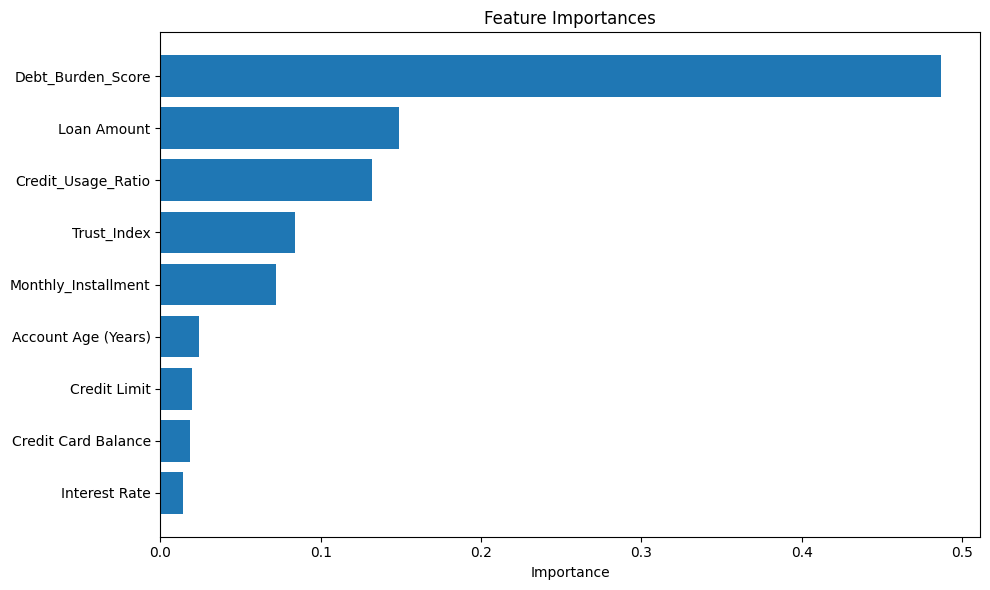

In [14]:
# Evaluates which input features (columns) are most helpful in predicting the target.
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#Save as Csv
#importance_df.to_csv('importance_df.csv', index=False)


## Exporting dataset

In [15]:
#df.to_csv('Loan_approval_predictions.csv', index=False)


In [16]:
import joblib
joblib.dump(model, 'Loan_approval_predictions.pkl')

['Loan_approval_predictions.pkl']